In [1]:
import muon as mu
import sys
sys.path.append("/home/zflu/multiomics")
mdata = mu.read_h5mu("/home/zflu/multiomics/dataset/bone_marrow_cells/44672347?private_link=f2623d650c3b93cb1d6f")

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will bec

In [2]:
import scanpy as sc
import numpy as np
import anndata as ad
adata_RNA = mdata['rna'].copy()
adata_ADT = mdata['adt'].copy()
# Keep only proteins with a gene connection and their corresponding coding genes
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["adt"].var["gene_connection"].values))
prot_genes_idx = [list(mdata["adt"].var["gene_connection"].values).index(g) for g in cm_genes]
cm_prot = mdata["adt"].var_names[prot_genes_idx]
RNA_shared = adata_RNA[:, cm_genes].copy()
ADT_shared = adata_ADT[:, cm_prot].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(cm_genes))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(cm_prot))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=1000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values

RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(np.array(RNA_counts).copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)

adata1 = ad.concat([ADT_shared, ADT_unshared], axis=1)
adata2 = ad.concat([RNA_shared, RNA_unshared], axis=1)

sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)

adata1.obs = adata_ADT.obs
adata2.obs = adata_RNA.obs

adata1.obsm['link_feat'] = adata1.X[:,:len(cm_genes)]
adata2.obsm['link_feat'] = adata2.X[:,:len(cm_genes)]

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [3]:
import mycode
mycode.smooth_link_feat(adata1, adata2, n_neighbors=15, metric='correlation', weight=0.3)
model = mycode.Model(adata1, adata2, batch_size=500, celltype_col='celltype', source_col='batch',
                           training_steps=5000, seed=1234,
                            n_latent=10, lambdaAE = 10.0, lambdaLA = 10.0, 
                            lambdaOT = 1.0, lambdamGAN = 1.0, lambdabGAN = 0.5, n_KNN = 10, mode = 'weak', prior = False)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/sampler.py:68: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


In [4]:
model.train() # train the model
model.eval() # get integrated latent representation of cells

Training started at: Mon Jul 14 01:21:57 2025
Step 0 | AE: 92.4977 | LA: 661.8283 | OT: 28.1046 | mGAN: -0.3873 | bGAN: -1.2362
Step 100 | AE: 13.1916 | LA: 0.6226 | OT: 0.8893 | mGAN: -1.2470 | bGAN: -0.6100
Step 200 | AE: 10.5195 | LA: 0.4300 | OT: 0.4878 | mGAN: -1.3698 | bGAN: -0.5993
Step 300 | AE: 9.7049 | LA: 0.1940 | OT: 0.3002 | mGAN: -1.3659 | bGAN: -0.5799
Step 400 | AE: 9.2595 | LA: 0.1443 | OT: 0.2545 | mGAN: -1.3689 | bGAN: -0.5912
Step 500 | AE: 9.3735 | LA: 0.1697 | OT: 0.2467 | mGAN: -1.3742 | bGAN: -0.5648
Step 600 | AE: 8.7977 | LA: 0.1419 | OT: 0.2192 | mGAN: -1.3705 | bGAN: -0.5999
Step 700 | AE: 9.2471 | LA: 0.1353 | OT: 0.2482 | mGAN: -1.3935 | bGAN: -0.6059
Step 800 | AE: 8.8184 | LA: 0.0932 | OT: 0.1874 | mGAN: -1.3580 | bGAN: -0.5771
Step 900 | AE: 8.2851 | LA: 0.0786 | OT: 0.1841 | mGAN: -1.3588 | bGAN: -0.5806
Step 1000 | AE: 8.3089 | LA: 0.0766 | OT: 0.2012 | mGAN: -1.3686 | bGAN: -0.5959
Step 1100 | AE: 8.4647 | LA: 0.0609 | OT: 0.2109 | mGAN: -1.3756 | bG

In [5]:
mdata.obsm["latent"]=model.latent

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

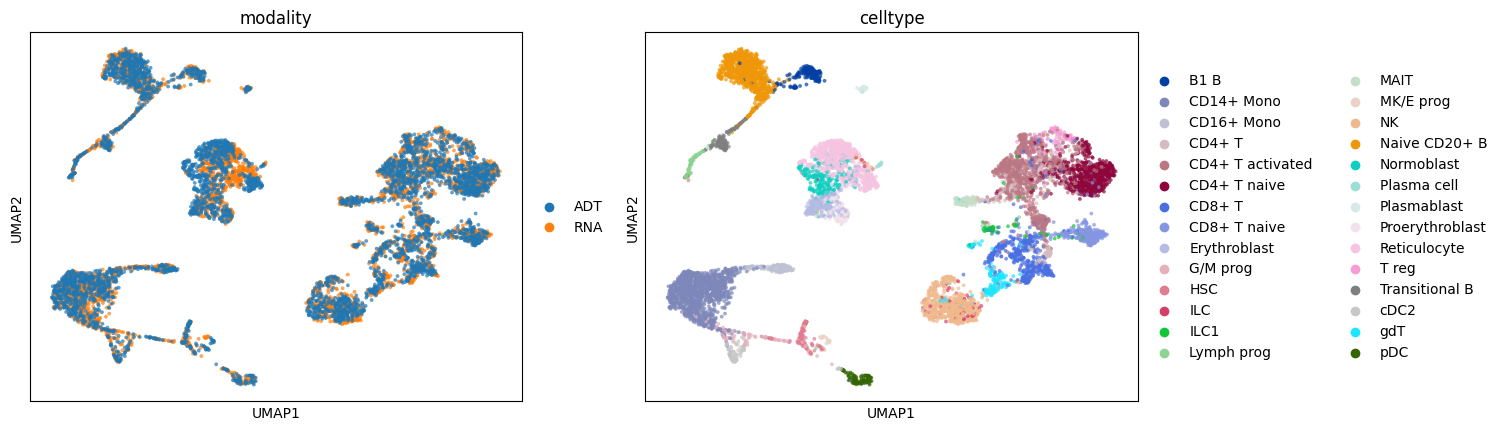

In [6]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=30, alpha=0.7)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

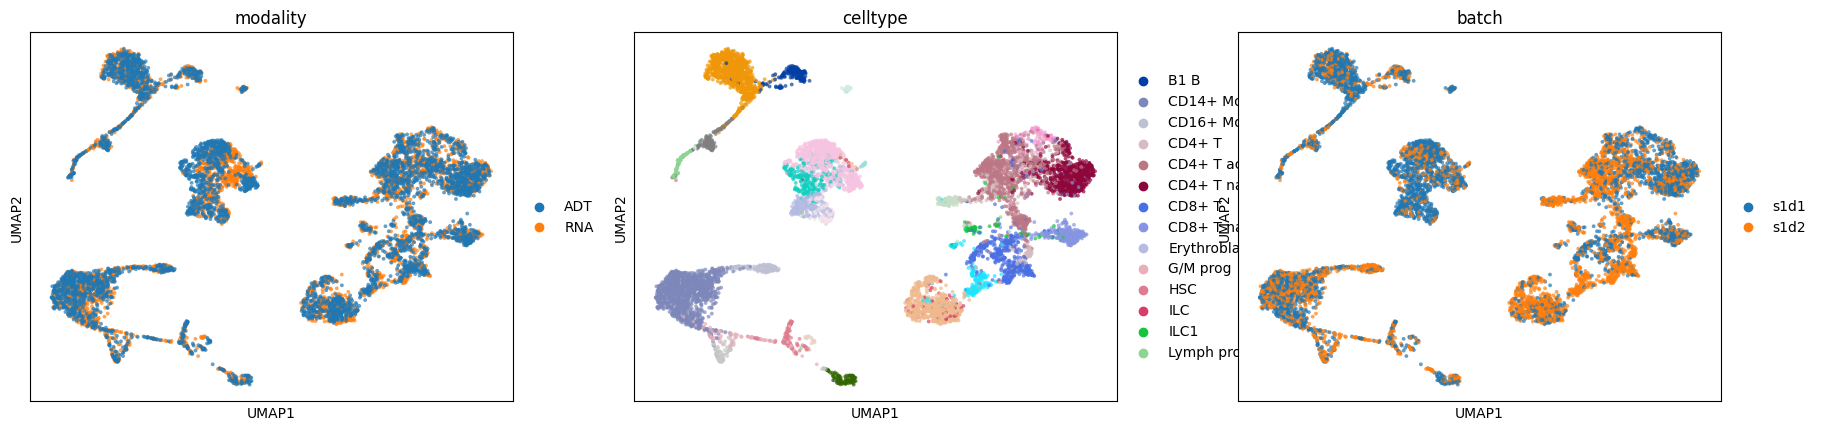

In [7]:
sc.pl.umap(mdata, color=["modality", "celltype","batch"], size=30, alpha=0.7)